In [29]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt
import os

In [30]:
from tqdm import tqdm_notebook

## FUNCTIONS

In [31]:
def readVideoFrames(filename):
    vid = imageio.get_reader(filename,  'ffmpeg')
    fps = vid.get_meta_data()['fps']
    num = 0
    frames = []
    while 1:
        try:
            image = vid.get_data(num)
            frames.append(image)
            num+=1
        except IndexError:
            break

    return np.array(frames), fps

In [32]:
def makeGrayScale(rgbVid):
    '''Converts numpy array vid to grayscale vid'''
    frames_bw = []
    for frame in rgbVid:
        frames_bw.append(np.around(np.dot(frame[:,:,:3], [0.2989, 0.587, 0.114])))
    return np.array(frames_bw)

In [33]:
def calculateDifferenceFrames(frames):
    dif_lst = []
    for i in range(1, frames.shape[0]):
        dif_lst.append(frames[i-1,:,:]-frames[i,:,:])
    return np.array(dif_lst)

In [34]:
def divideToMacroblocks(frame, macroblock_size=16):
    macroblocks = []
    m, n = frame.shape
    for i in range(0, m, macroblock_size):
        for j in range(0, n, macroblock_size):
            macroblock = frame[i:i+macroblock_size,j:j+macroblock_size]
    #         print (macroblock.shape)
            if macroblock.shape == (macroblock_size, macroblock_size):
    #             print ('works')
                macroblocks.append(macroblock)
            else:
    #             print ('something\'s goin\' on')
                try:
                    macroblock = np.vstack((macroblock, np.zeros(macroblock.shape[0], macroblock_size-macroblock.shape[1])))
                except TypeError:
                    pass
                try:
                    macroblock = np.hstack((macroblock, np.zeros(macroblock_size-macroblock.shape[0], macroblock.shape[1])))
                except TypeError:
                    pass
                macroblocks.append(macroblock)
    return np.array(macroblocks).reshape((int(m/macroblock_size), int(n/macroblock_size), macroblock_size, macroblock_size))

In [35]:
def createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size=16, k=16):
    neighborhood = []
#     print (indexOfMacroblock)
    for i in range(indexOfMacroblock[0]-k, indexOfMacroblock[0]+k+1, k):
        for j in range(indexOfMacroblock[1]-k, indexOfMacroblock[1]+k+1, k):
            if (i >= 0 and j >= 0 and i+macroblock_size < referenceFrame.shape[0] and j+macroblock_size < referenceFrame.shape[1]):
#                 print (i,j)
                neighborhood.append(referenceFrame[i:i+macroblock_size, j:j+macroblock_size])
            else:
                neighborhood += [None]
    return neighborhood

In [36]:
def SAD(referenceMacroblock, targetMacroblock):
#     print (targetMacroblock.shape, referenceMacroblock.shape)
    return np.sum(np.abs(targetMacroblock - referenceMacroblock))

In [37]:
def calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks):
    SADvals = []
        
    for macroblock in referenceFrame_neighbor_macroblocks:
        if macroblock is not None:
            SADvals.append(SAD(macroblock, targetMacroblock))
        else:
            SADvals.append(np.Inf)
    
    return np.array(SADvals).reshape((3,3))

In [38]:
def logarithmicSearch(referenceFrame, targetMacroblock, indexOfMacroblock, macroblock_size=16, k=16):
    if (k == 0):
        return indexOfMacroblock, referenceFrame[indexOfMacroblock[0]:indexOfMacroblock[0]+macroblock_size, indexOfMacroblock[1]:indexOfMacroblock[1]+macroblock_size] # motionVector END (To_WIDTH, To_HEIGHT), return Predicted Frame
    
    referenceFrame_neighbor_macroblocks = createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size, k)

    SAD_values = calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks)
#     print (SAD_values)
    indexofMinimumSAD = divmod(SAD_values.argmin(), SAD_values.shape[1])
    newIndexOfMacroblock = list(indexOfMacroblock)
    
    if (indexofMinimumSAD[0] == 0):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] - k
    elif (indexofMinimumSAD[0] == 2):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] + k
    
    if (indexofMinimumSAD[1] == 0):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] - k
    elif (indexofMinimumSAD[1] == 2):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] + k

    if (indexofMinimumSAD[0] == 1 and indexofMinimumSAD[1] == 1):
        newK = k//2
    else:
        newK = k       
#     print (indexofMinimumSAD)
#     print (newIndexOfMacroblock)
    return logarithmicSearch(referenceFrame, targetMacroblock, tuple(newIndexOfMacroblock), macroblock_size, newK)

In [39]:
def motionCompensation(referenceFrame, targetFrame, macroblock_size=16):
    predictedBlocks = []
    motionVectors = []
    
    targetMacroblocks = divideToMacroblocks(targetFrame, macroblock_size)
    for i in range(targetMacroblocks.shape[0]):
        for j in range(targetMacroblocks.shape[1]):
            motionVectorSTART = (i*macroblock_size, j*macroblock_size)
            indexofBlock = (i*macroblock_size, j*macroblock_size)
            motionVectorEND, prediction = logarithmicSearch(referenceFrame, targetMacroblocks[i,j,:,:], indexofBlock)
            predictedBlocks.append(prediction)
            motionVectors.append(motionVectorSTART+motionVectorEND)

#     print (len(motionVectors))
    predictedBlocks = np.array(predictedBlocks).reshape(targetMacroblocks.shape)
    motionVectors = np.array(motionVectors, dtype=(int,4)).reshape((targetMacroblocks.shape[0], targetMacroblocks.shape[1], 4))
    return predictedBlocks, motionVectors

In [40]:
def imageReconstructFromBlocks(blocks):
    lines = []
    for i in range(blocks.shape[0]):
        line = []
        for j in range(blocks.shape[1]):
            line.append(blocks[i,j,:,:])
        line = np.hstack(line)
        lines.append(line)
    return np.vstack(lines)

## Main

In [41]:
hall_monitor_cif = "resources\ex617\hall_monitor_cif.y4m"
resources_path = "resources\ex817"

## Preprocessing Step
  * Fetch Video
  * Take the First 100 Frames 
  * Convert to GrayScale for Further Convenience

In [42]:
videoFrames, fps = readVideoFrames(hall_monitor_cif)

In [43]:
videoFramesSample = videoFrames[:, :, :, :]
videoFramesSample.shape

(300, 288, 352, 3)

In [44]:
videoFramesSample = makeGrayScale(videoFramesSample)
videoFramesSample.shape

(300, 288, 352)

## Exercise pt.1
  * Create the Difference Frames  
  * Show Some Difference Frames

In [45]:
frameDifferenceSample = calculateDifferenceFrames(videoFramesSample)
frameDifferenceSample.shape

(299, 288, 352)

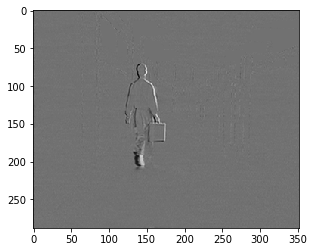

In [47]:
plt.imshow(frameDifferenceSample[51], cmap='gray')

## Exercise pt.2: Motion Compesation
* HYPOTHESIS: First Frame is I Frame; The Rest are P Frames
* Predict the next Frame from the Previous one
* Save Predicted Video for Future Reference

#### Example
* Show the Frame Differences Between the 51st and 52nd Frame of the Video

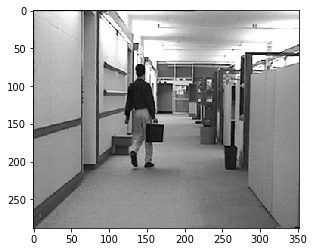

In [48]:
plt.imshow(videoFramesSample[50], cmap='gray')

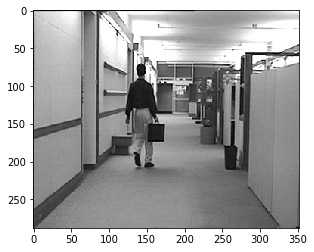

In [49]:
plt.imshow(videoFramesSample[51], cmap='gray')

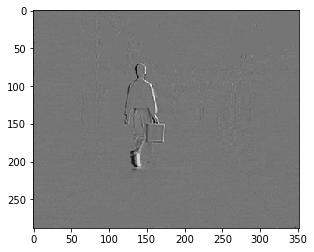

In [59]:
plt.imshow(videoFramesSample[50]-videoFramesSample[51], cmap='gray')

#### Run The Motion Compensation Algorithm for Each Frame of the Video
* Starting with the 1st Frame as is (I Frame) Predict the Next From the Previous Ones (P Frames)

In [51]:
compensatedVideoFramesSample = [videoFramesSample[0]]
motionVectors = []
for prevFrame, nextFrame in tqdm_notebook(zip(videoFramesSample, videoFramesSample[1:]), total=len(videoFramesSample[1:])):
    
    prediction, vectors = motionCompensation(prevFrame, nextFrame)
    predFrame = imageReconstructFromBlocks(prediction)
    compensatedVideoFramesSample.append(predFrame)
    motionVectors.append(vectors)    

HBox(children=(IntProgress(value=0, max=299), HTML(value='')))

#### Example
* Show the Frame Differences Between the 51st and 52nd Frame of the Motion Compensated Video

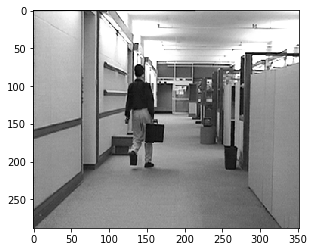

In [52]:
plt.imshow(compensatedVideoFramesSample[50], cmap='gray')

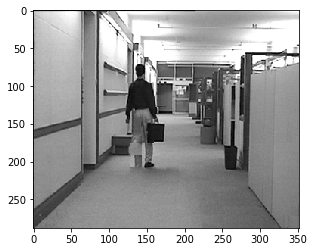

In [53]:
plt.imshow(compensatedVideoFramesSample[51], cmap='gray')

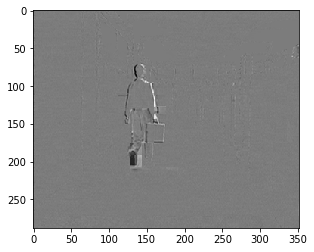

In [75]:
plt.imshow(compensatedVideoFramesSample[50]-compensatedVideoFramesSample[51], cmap='gray')

#### Save The Motion Compensated Video (For Future Reference)

In [55]:
writer = imageio.get_writer(os.path.join(resources_path,'hall_monitor_cif_motion_compensated.mp4'), fps=fps,mode="I")

for frame in compensatedVideoFramesSample:
    writer.append_data(frame)
writer.close()

C:\ProgramData\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
